## Importing and prepping data

In [1]:
import pandas as pd
import numpy as np
import diff_classifier.aws as aws
import diff_classifier.pca as pca

In [2]:
features = []
remote_folder = 'Gel_Studies/08_14_18_gel_validation' #Folder in AWS S3 containing files to be analyzed
bucket = 'ccurtis.data'
vids = 10
sizes = ['100', '200', '500']
nonnum = ['Particle Size', 'Video Number', 'Track_ID', 'Mean Mean_Intensity', 'Std Mean_Intensity', 'X', 'Y',
          'Mean X', 'Mean Y', 'Std X', 'Std Y',
          'Mean alpha', 'Std alpha', 'Mean D_fit', 'Std D_fit', 'Mean kurtosis', 'Std kurtosis',
          'Mean asymmetry1', 'Std asymmetry1', 'Mean asymmetry2', 'Std asymmetry2', 'Mean asymmetry3', 'Std asymmetry3',
          'Mean AR', 'Std AR', 'Mean elongation', 'Std elongation', 'Mean boundedness', 'Std boundedness',
          'Mean fractal_dim', 'Std fractal_dim', 'Mean trappedness', 'Std trappedness', 'Mean efficiency', 'Std efficiency',
          'Mean straightness', 'Std straightness', 'Mean MSD_ratio', 'Std MSD_ratio', 'Mean frames', 'Std frames',
          'Mean Quality', 'Std Quality', 'Mean SN_Ratio', 'Std SN_Ratio', 'Mean Deff1', 'Std Deff1', 'Mean Deff2', 'Std Deff2']

counter = 0
for size in sizes:
    for num in range(1, vids+1):
        try:
            filename = 'features_{}nm_XY{}.csv'.format(size, '%02d' % num)
            aws.download_s3('{}/{}'.format(remote_folder, filename), filename, bucket_name='ccurtis.data')
            fstats = pd.read_csv(filename, encoding = "ISO-8859-1", index_col='Unnamed: 0')
            print('{} size: {}'.format(filename, fstats.shape))
            fstats['Particle Size'] = pd.Series(fstats.shape[0]*[size], index=fstats.index)
            fstats['Video Number'] = pd.Series(fstats.shape[0]*[num], index=fstats.index)
            counter = counter + 1
            if counter == 1:
                fstats_tot = fstats
            else:
                fstats_tot = fstats_tot.append(fstats, ignore_index=True)
        except:
            print('skip filename {}'.format(filename))

skip filename features_100nm_XY01.csv
features_100nm_XY02.csv size: (18207, 67)
features_100nm_XY03.csv size: (18178, 67)
features_100nm_XY04.csv size: (20452, 67)
features_100nm_XY05.csv size: (19292, 67)
skip filename features_100nm_XY06.csv
skip filename features_100nm_XY07.csv
skip filename features_100nm_XY08.csv
features_100nm_XY09.csv size: (21766, 67)
skip filename features_100nm_XY10.csv
features_200nm_XY01.csv size: (6072, 67)
features_200nm_XY02.csv size: (6483, 67)
features_200nm_XY03.csv size: (6513, 67)
features_200nm_XY04.csv size: (6412, 67)
features_200nm_XY05.csv size: (5249, 67)
features_200nm_XY06.csv size: (5248, 67)
features_200nm_XY07.csv size: (4674, 67)
features_200nm_XY08.csv size: (5585, 67)
features_200nm_XY09.csv size: (5700, 67)
features_200nm_XY10.csv size: (5198, 67)
features_500nm_XY01.csv size: (5325, 67)
features_500nm_XY02.csv size: (4709, 67)
features_500nm_XY03.csv size: (4125, 67)
features_500nm_XY04.csv size: (1606, 67)
features_500nm_XY05.csv si

In [ ]:
fstats_tot.to_csv('features.csv')

In [ ]:
#PCA analyses with too many datapoints fail. You get rows with lots of NAs. I'm going to try making a subset of the data first
#and then do a PCA analysis on that.

#include all in analysis
import random
subset = np.sort(np.array(random.sample(range(fstats_tot.shape[0]), 500000)))
fstats_sub = fstats_tot.loc[subset, :].reset_index(drop=True)

In [3]:
#with equal sample sizes for each particle type
import random
counter = 0
for size in sizes:
    fstats_type = fstats_tot[fstats_tot['Particle Size']==size].reset_index(drop=True)
    print(fstats_type.shape)
    subset = np.sort(np.array(random.sample(range(fstats_type.shape[0]), 50000)))
    if counter == 0:
        fstats_sub = fstats_type.loc[subset, :].reset_index(drop=True)
    else:
        fstats_sub = fstats_sub.append(fstats_type.loc[subset, :].reset_index(drop=True), ignore_index=True)
    counter = counter + 1

(97895, 69)
(57134, 69)
(55041, 69)


In [4]:
#fstats = pd.read_csv(filename, encoding = "ISO-8859-1", index_col='Unnamed: 0')
fstats_num = fstats_sub.drop(nonnum, axis=1)
fstats_raw = fstats_num.as_matrix()
#fstats

## PCA analysis

The pca.pca_analysis function provides a completely contained PCA analysis of the input trajectory features dataset. It includes options to impute NaN values (fill in with average values or drop them), and to scale features. Read the docstring for more information. 

In [7]:
pcadataset = pca.pca_analysis(fstats_tot, dropcols=nonnum, n_components=8)

Cumulative explained variance:
0 component: 0.28549724914465946
1 component: 0.43277465906959844
2 component: 0.5599302704042366
3 component: 0.6468753090305863
4 component: 0.7121157942554476
5 component: 0.7563362853493922
6 component: 0.7991482620155288
7 component: 0.8399455422276639


In [15]:
pcadataset.components.to_csv('components.csv')

In [18]:
pcadataset.prcomps

,0,1,2,3,4,5,6,7
0,asymmetry2,Deff1,Quality,D_fit,kurtosis,Deff2,frames,MSD_ratio
1,asymmetry3,elongation,frames,alpha,Mean_Intensity,kurtosis,kurtosis,kurtosis
2,asymmetry1,AR,trappedness,straightness,frames,straightness,fractal_dim,Deff1
3,elongation,asymmetry3,boundedness,efficiency,Quality,Deff1,efficiency,D_fit
4,fractal_dim,asymmetry2,SN_Ratio,kurtosis,SN_Ratio,MSD_ratio,Mean_Intensity,efficiency


The pca.kmo function calculates the Kaiser-Meyer-Olkin statistic, a measure of sampling adequacy. Check the docstring for more information.

In [14]:
kmostat = pca.kmo(pcadataset.scaled)

0.874299931374


In [ ]:
import scipy.stats as stat
stat.bartlett(pcadataset.scaled[0, :], pcadataset.scaled[1, :], pcadataset.scaled[2, :], pcadataset.scaled[3, :])

In [ ]:
newstr = ''
for i in range(pcadataset.scaled.shape[0]-1):
    newstr = newstr + 'pcadataset.scaled[{}, :], '.format(i)

newstr = 'stat.bartlett(' + newstr + 'pcadataset.scaled[{}, :])'.format(i+1)

In [ ]:
test = eval(newstr)

In [ ]:
test

## Visualization

Users can then compare average principle component values between subgroups of the data. In this case, all particles were taken from the same sample, so there are no experimental subgroups. I chose to compare short trajectories to long trajectories, as I would expect differences between the two groups.

In [8]:
import numpy as np
ncomp = 8
dicti = {}
#test = np.exp(np.nanmean(np.log(pcadataset.final[pcadataset.final['Particle Size']==200].as_matrix()), axis=0))[-6:]
#test1 = np.exp(np.nanmean(np.log(pcadataset.final[pcadataset.final['Particle Size']==500].as_matrix()), axis=0))[-6:]
dicti[0] = np.nanmean(pcadataset.final[pcadataset.final['Particle Size']=='100'].values[:, -ncomp:], axis=0)
dicti[1] = np.nanmean(pcadataset.final[pcadataset.final['Particle Size']=='200'].values[:, -ncomp:], axis=0)
dicti[2] = np.nanmean(pcadataset.final[pcadataset.final['Particle Size']=='500'].values[:, -ncomp:], axis=0)

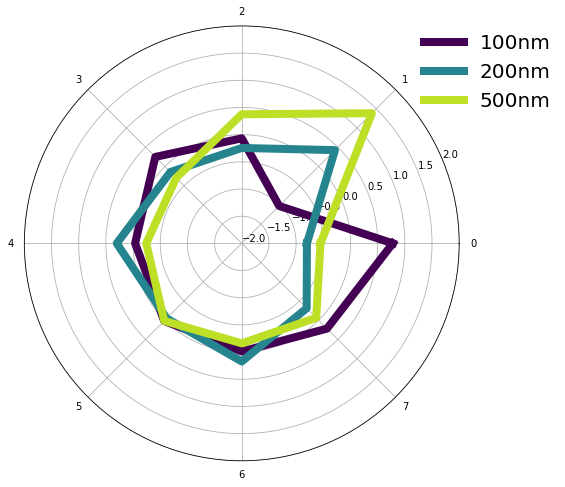

In [17]:
pca.plot_pca(dicti, savefig=True, labels=['100nm', '200nm', '500nm'], rticks=np.linspace(-2, 2, 9))

The variable pcadataset.prcomps shows the user the major contributions to each of the new principle components. When observing the graph above, users can see that there are some differences between short trajectories and long trajectories in component 0 (asymmetry1 being the major contributor) and component 1 (elongation being the major contributor).

In [ ]:
pcadataset.prcomps

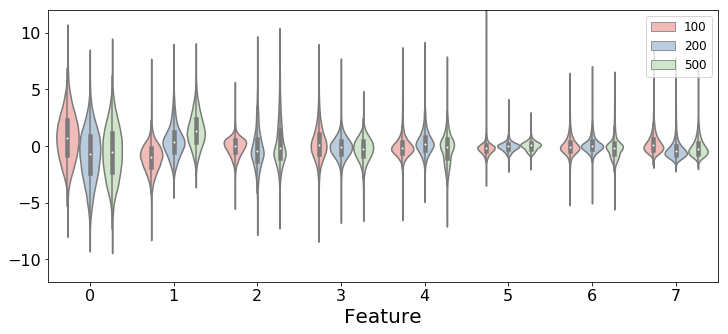

In [10]:
labels=['100', '200', '500']
feats = pca.feature_violin(pcadataset.final, label='Particle Size', lvals=labels, fsubset=8, yrange=[-12, 12])

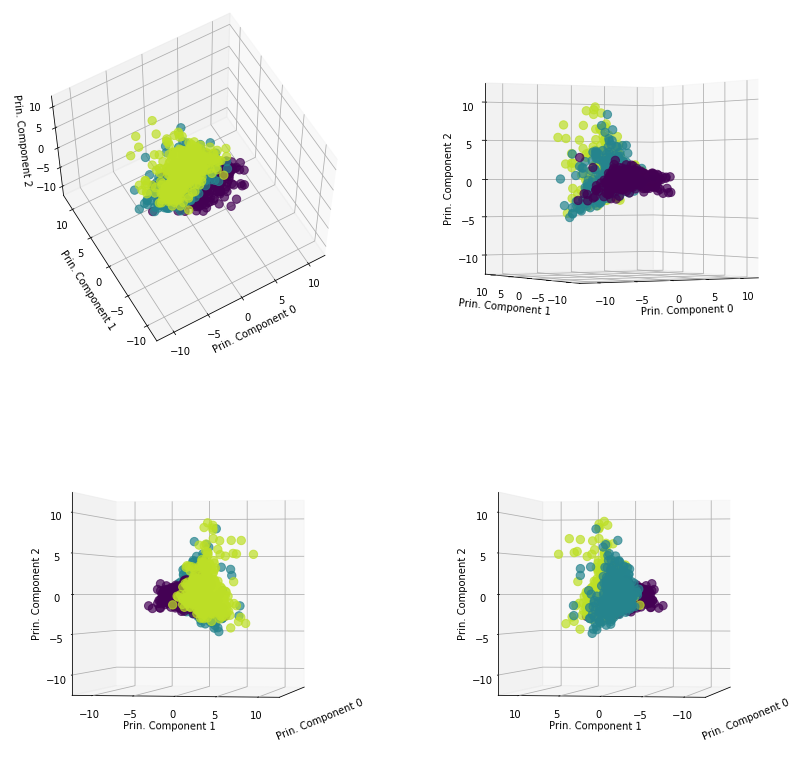

In [11]:
fstats1 = pca.feature_plot_3D(pcadataset.final, label='Particle Size', lvals=labels, randcount=400, ylim=[-12, 12],
                              xlim=[-12, 12], zlim=[-12, 12])

In [12]:
ncomp = 8
trainp = np.array([])
testp = np.array([])

for i in range(0, 20):
    KNNmod, X, y = pca.build_model(pcadataset.final, 'Particle Size', labels, equal_sampling=True,
                                       tsize=500, input_cols=ncomp, model='MLP', NNhidden_layer=(6, 2))
    trainp = np.append(trainp, pca.predict_model(KNNmod, X, y))
    
    X2 = pcadataset.final.values[:, -ncomp:]
    y2 = pcadataset.final['Particle Size'].values
    testp = np.append(testp, pca.predict_model(KNNmod, X2, y2))
    print('Run {}: {}'.format(i, testp[i]))

Run 0: 0.739177417051459
Run 1: 0.7223544532774789
Run 2: 0.7308373399343077
Run 3: 0.7235445327747894
Run 4: 0.7402627695530062
Run 5: 0.7337696958156805
Run 6: 0.7305422002189746
Run 7: 0.7285714285714285
Run 8: 0.735021659446851
Run 9: 0.7321892702432522
Run 10: 0.7440472223544533
Run 11: 0.7274432332079783
Run 12: 0.7339125053553578
Run 13: 0.7445280144713667
Run 14: 0.7228780882562955
Run 15: 0.7456324082448708
Run 16: 0.7309373066120817
Run 17: 0.7396010853525016
Run 18: 0.7266768220117104
Run 19: 0.7183938687104299


In [13]:
print('{} +/ {}'.format(np.mean(trainp), np.std(trainp)))
print('{} +/ {}'.format(np.mean(testp), np.std(testp)))

0.7236333333333332 +/ 0.018244603463916563
0.7325160660732137 +/ 0.007663070576063939


In [ ]:
fstats_num